# Develop algo

In [1]:
import os
os.chdir("/workspaces/BAIT")

import numpy as np
import pandas as pd
import torch
import seaborn as sns
from analysis.results_utils import *

In [2]:
from analysis.results_utils import load_csv

FILE_PATH = "./analysis/results/results_combined.csv"
df = load_csv(FILE_PATH)

In [3]:
from analysis.results_utils import get_tensors, print_histograms
import numpy as np
import pandas as pd
import torch
import seaborn as sns
# which one to learn?

# get best performers at low sparsity
top10 = df[df["final_sparsity"] == 0.2].nlargest(3, columns=["accuracy"])
files = top10["file"].tolist()
experiment = {
    # "init_id": "47ee372c-ce4a-11ec-8633-0242ac120002",
    # "sparsity": 0.2,
    "experiment_type": "i10",
    "algo": "synflow",
    # "layer_name": "fc_layers.0.weight",
    "kind": "initial_weight"
}

df_tensors = pd.DataFrame(get_tensors(**experiment, masked=True))

# extract tensors (all layers) and make histogram
all_ts = [t[0] for t in df_tensors["t"].tolist()]
ts = torch.cat(tuple(t.flatten() for t in all_ts))

# learn the kde
from sklearn.neighbors import KernelDensity
X = ts.detach().cpu().numpy().reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(X)

# sns.histplot(X)
# sns.histplot(kde.sample(100000))
# print_histograms(df_tensors, row=None, col=None, label=None, kde=True)

# save kde to file

# import dill

# with open("kde.dill", "wb") as f:
#     dill.dump(kde, f)


Loading mnist dataset.


In [4]:
def print_hist(x, y):
    import pandas as pd
    df = pd.DataFrame(y).T
    df.columns = x.tolist()
    df = df.T.reset_index()

    sns.set(rc={'figure.figsize':(5, 5)})
    sns.barplot(data=df, x="index", y=0)

# mi=-1
# ma=1
# bins=100
# cols = np.linspace(mi, ma, bins)


# t_kde = torch.from_numpy(kde.sample(10000000))
# h_soll = torch.histc(t_kde, bins=bins, min=mi, max=ma) / torch.numel(t_kde)
# print_hist(cols, h_soll)

In [5]:
# calculate deviation on a single tensor
import numpy as np
# demo tensor:
experiment = {
    "init_id": "47ee372c-ce4a-11ec-8633-0242ac120002",
    "sparsity": 0.2,
    "experiment_type": "i10",
    "algo": "synflow",
    "layer_name": "fc_layers.0.weight",
    "kind": "initial_weight"
}
t = get_tensor(**experiment, masked=True).detach().cpu()



# h_ist = torch.histc(t, bins=bins, min=mi, max=ma) / torch.numel(t)
# print_hist(cols, h_ist)


In [ ]:
# with open("kde.dill", "rb") as f:
#     kde2 = dill.load(f)

In [ ]:
h_diff = h_ist - h_soll 
print_hist(cols, h_diff)

In [ ]:
torch.argmax(h_diff).item()

In [ ]:
import pandas as pd
df = pd.DataFrame(h_diff).T
df.columns = cols.tolist()
df = df.T.reset_index()
df.columns = ["bin", "pct"]
bounds = np.linspace(mi, ma, bins + 1)
df["from"] = bounds[:-1]
df["to"] = bounds[1:]
df = df.sort_values(by=["pct"], ascending=False)
df


In [ ]:
bounds = np.linspace(mi, ma, bins + 1)
froms = bounds[:-1]
tos = bounds[1:]

scores = t.clone().detach()
for frm, to in zip(froms, tos):
    cond = (scores >= frm) & (scores < to)
    numel = torch.masked_select(t, cond).numel()
    scores = torch.where(cond, scores + numel, scores) # the bins with most items score highest

scores = 1/scores # most items score lowest, get selected


In [ ]:
t

# Test it

In [1]:
import os
os.chdir("/workspaces/BAIT")
from copy import copy
from src.experiment import Experiment, get_instance_id, load_base_model_weights
from utils.params import ModelParams, DataParams, TrainingPhase, PruningPhase
import re
from datetime import datetime
from utils.monitor import MONITOR
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from analysis.results_utils import *

algo = "uprune"
sparsity = 0.2
# base_model_id = "47ee372c-ce4a-11ec-8633-0242ac120002"

base_experiment = Experiment()
base_experiment.repeats = 1 # single repeat but there will be 3 container instances resulting in 3 repeats

base_experiment.model_params = ModelParams(model="lenet_300_100", init_strategy="bi-modal")
base_experiment.data_params = DataParams(dataset="mnist")
expr = copy(base_experiment)
expr.pruning_phases = [
    PruningPhase(
        strategy=algo,
        sparsity=sparsity,
        prune_epochs=1
    ),
    TrainingPhase(
        train_epochs=100
    )
]
expr.name = f"oneshot_{algo}_{sparsity}"
time = re.sub("[-_\. :]", "", str(datetime.now()))
expr.full_name = f"{expr.name}_{get_instance_id()}_{time}"
MONITOR.start(expr.full_name)
s = State(expr.model_params, expr.data_params, expr)
# load_base_model_weights(base_model_id, s.model)
# s.base_model_id = base_model_id
s.bake_initial_state()

# force reinit
# s.model._initialize_weights()


Creating lottery-lenet_300_100 model.


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KernelDensity from version 1.0.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading mnist dataset.


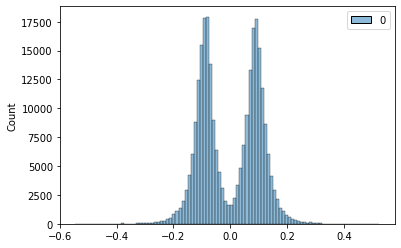

In [16]:
def plot_model_weights(s):
    masks = [m for m, _ in s.pruner.masked_parameters]
    params = [param for name, param in s.model.named_parameters() if name.endswith(".weight")]
    params = [torch.masked_select(t, (m>0)) for t, m in zip(params, masks)]
    t = torch.cat(params).flatten().detach().cpu().flatten().numpy()
    sns.histplot(pd.DataFrame(t), bins=100)
s.set_pruner(expr.pruning_phases[0])
plot_model_weights(s)

<AxesSubplot:ylabel='Count'>

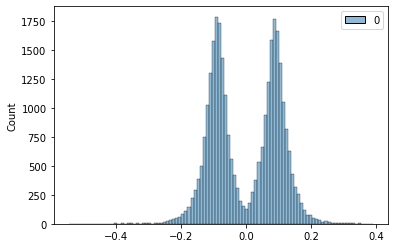

In [10]:
import dill
self = s.model
with open("kde.dill", "rb") as f:
    self.kde = dill.load(f)

m = list(self.modules())[3]
m.weight.data.copy_(torch.from_numpy(self.kde.sample(m.weight.numel())).float().reshape(m.weight.size()))
t = m.weight.flatten().detach().cpu().flatten().numpy()
sns.histplot(pd.DataFrame(t), bins=100)

In [7]:
from src.phase_actions import one_shot_pruning

one_shot_pruning(s, expr.pruning_phases[0])

one-shot pruning with uprune until 0.2 sparsity


100%|██████████| 1/1 [00:00<00:00, 53.96it/s]


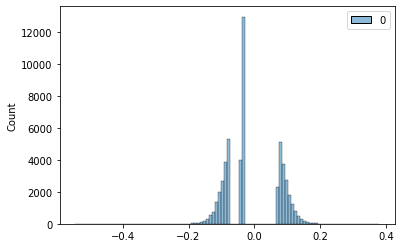

In [8]:
plot_model_weights(s)

<AxesSubplot:xlabel='0', ylabel='1'>

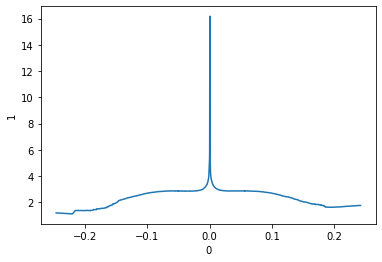

In [26]:
from utils.environment import ENV
s.set_pruner(expr.pruning_phases[0])

device = ENV.device
self = s.pruner
# self.bounds = np.linspace(self.min, self.max, self.bins + 1)
p = self.masked_parameters[0][1]
kde_samples = torch.reshape(torch.tensor(self.kde.sample(p.flatten().numel())).squeeze(), p.size()).to(device)

# as it is in pruner:
p_sort, p_sort_i = torch.sort(p.flatten())
kde_sort, _ = torch.sort(kde_samples.flatten())
# diff = torch.abs(p_sort - kde_sort)
diff = p_sort - kde_sort
diff = 1/torch.abs(diff)
diff = torch.log(diff)
scores = diff.gather(0, p_sort_i.argsort(0))
scores = scores.reshape(p.size())

def print_hist(x, y):
    import pandas as pd
    df = pd.DataFrame(y.detach().cpu().numpy()).T
    df.columns = x.tolist()
    df = df.T.reset_index()

    sns.set(rc={'figure.figsize':(5, 5)})
    sns.barplot(data=df, x="index", y=0)
# sns.histplot(scores.detach().cpu().numpy().flatten())
# print_hist(self.cols, torch.histc(scores, self.bins, self.min, self.max))
t1 = p
t2 = scores


import numpy as np

combined = np.stack(
    [
        t1.flatten().detach().cpu().numpy(), 
        t2.flatten().detach().cpu().numpy()
    ]
    )


import pandas as pd

df = pd.DataFrame(combined).T
sns.lineplot(data=df, x=0, y=1 , legend =False)

<AxesSubplot:xlabel='0', ylabel='1'>

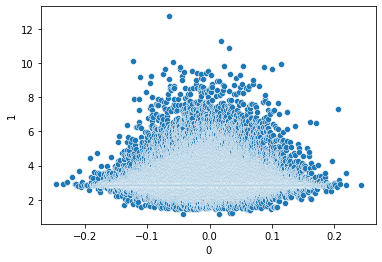

In [ ]:
# number of global elements
# ratio of bins soll
# ratio of bins ist
# diff ist - soll
# für alle bins wo positiv: wieder normalisieren dass summe 1 gibt
# dann ausrechenen wie viele elemente raus müssen, magnitute scoring, für den rest magnitude = 1?

# bin weises magnitude pruning?
# magnitude + bin ratio to be pruned?

In [60]:
from utils.environment import ENV
s.set_pruner(expr.pruning_phases[0])

device = ENV.device
self = s.pruner
self.bounds = np.linspace(self.min, self.max, self.bins + 1)



# def kthvalue_in_bin(try)

# k = 100
# TODO: speedup with k values instead of every singel one?






# # find the bin that is the one most in need of adjustment
# index_of_max_ratio = torch.argmax(global_diff_ratio)
# lower_bound = lower_bounds[index_of_max_ratio.item()]


# for each layer, for each bin take numel * bin size (which is the ratio that it needs to be pruned) elements

# all_ps = get_all_params_without_score()
# global_minimal_value_in_bin = torch.min(all_ps)

# p = self.masked_parameters[0][1]
# scores = list(self.scores.items())[0][1]
lower_bounds = self.bounds[:-1]
upper_bounds = self.bounds[1:]

all_params = torch.cat([p.flatten() for _, p in self.masked_parameters])
global_numel = all_params.numel()
global_kde = torch.histc(torch.from_numpy(self.kde.sample(1000000)), self.bins, self.min, self.max).to(device)

# create all masks and set to 0
for (_, p) in self.masked_parameters:
    self.scores[id(p)] = torch.zeros_like(p)

def get_all_params_without_score():
    return torch.cat([torch.masked_select(p, scores == 0) for (_, p), (s_id, scores) in zip(self.masked_parameters, self.scores.items())])

# calculate for all bins by how much they deviate from the target bin
global_h = torch.histc(get_all_params_without_score(), self.bins, self.min, self.max).to(device)
global_diff = (global_h / torch.sum(global_h)) - (global_kde / torch.sum(global_kde))
global_diff = torch.where(global_diff > 0., global_diff, 0.) # remove entries for bins that have to few items in them
global_diff_ratio = global_diff / torch.sum(global_diff)


for (_, p), (s_id, scores) in zip(self.masked_parameters, self.scores.items()):
    layer_numel = p.numel()
    sorted, indices = torch.sort(global_h, descending=True)
    for bin_rank, (bin_items, bin_i) in enumerate(zip(sorted, indices)):
        print(f" processing bin ranked #{bin_rank}: bin {bin_i} {bin_items}")

        # per bin:
        lower_bound = lower_bounds[bin_i]
        upper_bound = upper_bounds[bin_i]

        # how many items are in bin?
        scope = (p >= lower_bound) & (p < upper_bound) & (scores == 0) # TODO: remove those which already have a score?
        numel_scope = torch.sum(scope).item()
        print(f"{numel_scope} values in scope")
        # how much should i prune?
        ratio_to_prune = global_diff_ratio[bin_i].item()
        k = int(numel_scope * ratio_to_prune)

        print(f"{ratio_to_prune} pct of which should be pruned -> k = {k}")
        if k > 0:
            kth = torch.kthvalue(
                torch.where(
                    scope,
                    p.double(),
                    1.
                ).flatten(),
                k
            )
            kth_upper_bound = kth.values.item()

            scope = scope & (p < kth_upper_bound)
        print(f"{torch.sum(scope).item()} values remain in scope")

        # scope now marks the values, where the score should be rank of bin + abs value, for the rest leave scores alone
        avg_score = torch.sum(torch.where(scope, bin_rank + torch.abs(p).double(), 0.)) / torch.sum(scope).double()
        print(f"average score given to items in scope: {avg_score.item()}")
        scores = torch.where(scope, bin_rank + torch.abs(p), scores)


 processing bin ranked #0: bin 50 39360.0
36397 values in scope
0.2401409268369471 pct of which should be pruned -> k = 8740
8739 values remain in scope
average score given to items in scope: 0.002346902157981821
 processing bin ranked #1: bin 49 39096.0
36115 values in scope
0.23906651600067233 pct of which should be pruned -> k = 8633
8632 values remain in scope
average score given to items in scope: 1.017522664463076
 processing bin ranked #2: bin 48 33739.0
30878 values in scope
0.18218826048253411 pct of which should be pruned -> k = 5625
5624 values remain in scope
average score given to items in scope: 2.0379591658817415
 processing bin ranked #3: bin 51 33588.0
30868 values in scope
0.17810005127551573 pct of which should be pruned -> k = 5497
5496 values remain in scope
average score given to items in scope: 3.0216418816935096
 processing bin ranked #4: bin 52 25277.0
22826 values in scope
0.08012706697848503 pct of which should be pruned -> k = 1828
1827 values remain in scop

In [85]:
def print_hist(x, y):
    import pandas as pd
    df = pd.DataFrame(y.detach().cpu().numpy()).T
    df.columns = x.tolist()
    df = df.T.reset_index()

    sns.set(rc={'figure.figsize':(5, 5)})
    sns.barplot(data=df, x="index", y=0)

print_hist(self.cols, p)

ValueError: Length mismatch: Expected axis has 300 elements, new values have 100 elements

for i = number of elemntes globally
    h for the weights without a score
    bin = the bin with the biggest diff (index of max in h)
    from, to = the range of the bin (we only need from? abs value?)
    max of the range of the bin
    for layer = every layer:
        if the layer contains the max of the bin with the max diff, this layer's score gets score i + abs(val)
        this value is excluded from future scoring by checking if the correspoing score already is > 0

    if all scores len == layers len: exit

0.799992486851991


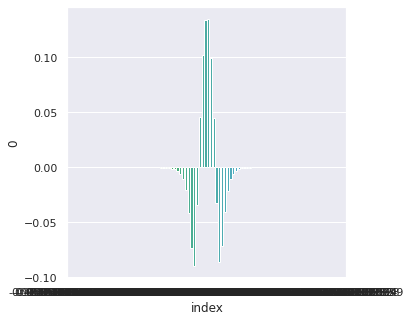

In [262]:
from utils.environment import ENV
s.set_pruner(expr.pruning_phases[0])

device = ENV.device
self = s.pruner
def score_layer(layer: torch.Tensor, global_bin_ranking):

    # h = torch.histc(layer, self.bins, self.min, self.max)
    # sort bins
    # somehow keep an index
    # be able to translate 
    

    froms = self.bounds[:-1]
    tos = self.bounds[1:]
    index = 1 / torch.reshape(torch.arange(layer.numel()), layer.size()).to(device)
    scores = layer.clone().detach().abs_()
    for i, (frm, to) in enumerate(zip(froms, tos)):
        cond = (scores >= frm) & (scores < to)
        numel = torch.masked_select(torch.abs(layer), cond).numel()
        # s_max = torch.max(scores)
        # scores = scores / s_max
        scores = torch.where(cond, torch.abs(scores) + numel + index, scores)
    scores = 1/scores # most items score lowest, get selected
    return scores


# bins_d = [{"bin_i": i, "rank": 0, "n": n} for i, n in enumerate(global_h.tolist())]
# bins_d = [{**d, "rank":i} for i, d in enumerate(sorted(bins_d, key=lambda x: x["n"], reverse=True))]

global_kde = torch.histc(torch.from_numpy(self.kde.sample(1000000)), self.bins, self.min, self.max).to(device)


numel = 1000

sparsity = 0.5
# global_h = torch.histc(torch.cat([p.flatten() for _, p in self.masked_parameters]), self.bins, self.min, self.max).to(device)
# 
# # global_diff_ratio = torch.where(global_diff < 0., 0., global_diff)
# global_diff_ratio = global_diff / torch.sum(global_diff)

N = 10
    
for _, p in self.masked_parameters:
    for i in range(N):
        global_h = torch.histc(torch.cat([p.flatten() for _, p in self.masked_parameters]), self.bins, self.min, self.max).to(device)
        global_diff = (global_h / torch.sum(global_h)) - (global_kde / torch.sum(global_kde))
        global_diff_ratio = torch.where(global_diff < 0., 0., global_diff)
        global_diff_ratio = global_diff_ratio / torch.sum(global_diff_ratio)
        
        layer = torch.clone(p.data).detach()
        scores = layer.clone().detach().abs_()

        elems_per_bin = (global_diff_ratio * torch.histc(layer, self.bins, self.min, self.max).to(device)) / N

        froms = self.bounds[:-1]
        tos = self.bounds[1:]
        index = 1 / torch.reshape(torch.arange(layer.numel()), layer.size()).to(device)
        for i, (frm, to) in enumerate(zip(froms, tos)):
            cond = (scores >= frm) & (scores < to)
            numel = torch.masked_select(torch.abs(layer), cond).numel()
            # s_max = torch.max(scores)
            # scores = scores / s_max
            scores = torch.where(cond, scores + i, scores)
        scores = 1/scores # most items score lowest, get selected
        # global_diff_ratio = global_diff_ratio - (global_diff_ratio / N)

    self.scores[id(p)] = scores

# print(torch.sum(elems_per_bin).item())
# print(elems_to_prune)


def print_hist(x, y):
    import pandas as pd
    df = pd.DataFrame(y.detach().cpu().numpy()).T
    df.columns = x.tolist()
    df = df.T.reset_index()

    sns.set(rc={'figure.figsize':(5, 5)})
    sns.barplot(data=df, x="index", y=0)

print_hist(self.cols, (global_h / torch.sum(global_h)) - (global_kde / torch.sum(global_kde)))

# bins_to_prune = 





# def print_nr_duplicates(t):
#     unique_values, value_count = torch.unique(t, return_counts=True)
#     mask_duplicates = value_count > 1
#     print(torch.sum(mask_duplicates).item())

# print_nr_duplicates(torch.cat([p.flatten() for _, p in self.masked_parameters]).detach())

s.pruner.mask(0.8, "global")
remaining, total = s.pruner.stats()
print(remaining/total)
# plot_model_weights(s)

In [213]:
elems_to_prune

200.0

In [206]:
bins_d

[{'bin_i': 50, 'rank': 0, 'n': 39360.0},
 {'bin_i': 49, 'rank': 1, 'n': 39096.0},
 {'bin_i': 48, 'rank': 2, 'n': 33739.0},
 {'bin_i': 51, 'rank': 3, 'n': 33588.0},
 {'bin_i': 52, 'rank': 4, 'n': 25277.0},
 {'bin_i': 47, 'rank': 5, 'n': 25094.0},
 {'bin_i': 53, 'rank': 6, 'n': 16461.0},
 {'bin_i': 46, 'rank': 7, 'n': 16374.0},
 {'bin_i': 54, 'rank': 8, 'n': 9426.0},
 {'bin_i': 45, 'rank': 9, 'n': 9346.0},
 {'bin_i': 44, 'rank': 10, 'n': 4944.0},
 {'bin_i': 55, 'rank': 11, 'n': 4866.0},
 {'bin_i': 56, 'rank': 12, 'n': 2214.0},
 {'bin_i': 43, 'rank': 13, 'n': 2198.0},
 {'bin_i': 42, 'rank': 14, 'n': 1060.0},
 {'bin_i': 57, 'rank': 15, 'n': 1017.0},
 {'bin_i': 58, 'rank': 16, 'n': 497.0},
 {'bin_i': 41, 'rank': 17, 'n': 494.0},
 {'bin_i': 59, 'rank': 18, 'n': 261.0},
 {'bin_i': 40, 'rank': 19, 'n': 258.0},
 {'bin_i': 39, 'rank': 20, 'n': 170.0},
 {'bin_i': 60, 'rank': 21, 'n': 132.0},
 {'bin_i': 61, 'rank': 22, 'n': 69.0},
 {'bin_i': 38, 'rank': 23, 'n': 63.0},
 {'bin_i': 37, 'rank': 24, '

In [185]:
from utils.environment import ENV
s.set_pruner(expr.pruning_phases[0])

device = ENV.device
self = s.pruner

def get_global_duplicates(all_layers):
    # all unique values
    unique_values, value_count = torch.unique(all_layers, return_counts=True)
    mask_duplicates = value_count > 1
    values_with_duplicates = torch.masked_select(unique_values, mask_duplicates)
    # print(torch.sum(mask_duplicates).item())
    return values_with_duplicates

def add_global_index_to_duplicate_values(t, global_duplicates):
    while True:
        mask_values_with_duplicates = t.cpu().apply_(lambda x: x in set(values_with_duplicates.tolist())).to(device).bool() # very slow

        t = t.to(device)
        # wiggle_duplicates = torch.arange(t.numel()).to(device) * 1e-6
        wiggle_duplicates = torch.arange(t.numel()).to(device) * 1e-6
        t = torch.where(mask_values_with_duplicates, t + wiggle_duplicates, t)
        unique_values, value_count = torch.unique(t, return_counts=True)
        mask_duplicates = value_count > 1
        values_with_duplicates = torch.masked_select(unique_values, mask_duplicates)
        if torch.sum(mask_duplicates).item() == 0:
            return t


def score_layer(layer: torch.Tensor):

    # h = torch.histc(layer, self.bins, self.min, self.max)
    # sort bins
    # somehow keep an index
    # be able to translate 
    

    froms = self.bounds[:-1]
    tos = self.bounds[1:]
    index = 1 / torch.reshape(torch.arange(layer.numel()), layer.size()).to(device)
    scores = layer.clone().detach()
    for i, (frm, to) in enumerate(zip(froms, tos)):
        cond = (scores >= frm) & (scores < to)
        numel = torch.masked_select(torch.abs(layer), cond).numel()
    
        scores = torch.where(cond, torch.abs(scores) + numel + index, scores)
    scores = 1/scores # most items score lowest, get selected
    return scores

# global_h = torch.histc(torch.cat([p.flatten() for _, p in self.masked_parameters]), self.bins, self.min, self.max)
# bins_d = {i: n for i, n in enumerate(global_h.tolist())}

# for _, p in self.masked_parameters:
#     # while torch.cat([v for k, v in self.scores]).nonzero()
#     self.scores[id(p)] = score_layer(p)

# remaining, total = s.pruner.stats()
# s.pruner.mask(expr.pruning_phases[0].sparsity, "global")
# print(remaining/total)
# plot_model_weights(s)

In [99]:
t = torch.cat([p.flatten() for _, p in self.masked_parameters]).detach()


# all unique values
unique_values, inverse_indices, value_count = torch.unique(t, return_counts=True, return_inverse=True)
mask_duplicates = value_count > 1
values_with_duplicates = torch.masked_select(unique_values, mask_duplicates)
print(torch.sum(mask_duplicates).item())

mask_values_with_duplicates = t.cpu().apply_(lambda x: x in set(values_with_duplicates.tolist()))

t = t.to(device)
mask_values_with_duplicates = mask_values_with_duplicates.to(device).bool()
wiggle_duplicates = torch.arange(t.numel()).to(device) * 1e-6
t = torch.where(mask_values_with_duplicates, t + wiggle_duplicates, t)
unique_values, value_count = torch.unique(t, return_counts=True)
mask_duplicates = value_count > 1
values_with_duplicates = torch.masked_select(unique_values, mask_duplicates)
print(torch.sum(mask_duplicates).item())

572
1


In [ ]:
t = torch.cat([p.flatten() for _, p in self.masked_parameters]).detach()

In [96]:
# def mag_prune_n(t, n, lower_limit):
n = 10
t = torch.cat([p.flatten() for _, p in self.masked_parameters]).detach()
candidates = torch.abs(t) > lower_limit
torch.kthvalue(input, k, dim=None, keepdim=False,

0


In [140]:
mask

tensor 140414231048000 with len torch.Size([300, 784])

In [23]:
torch.max(t).item()

0.3814021944999695

In [177]:


def print_nr_duplicates(t):
    unique_values, value_count = torch.unique(t, return_counts=True)
    mask_duplicates = value_count > 1
    print(torch.sum(mask_duplicates).item())

# single_layer_deduplicate(t):
t = self.masked_parameters[0][1].detach()
print_nr_duplicates(t)

# print(t.size())
unique_values, inverse_indices, value_count = torch.unique(t, return_counts=True, return_inverse=True)

# print(inverse_indices.size())
# print(torch.sum(value_count > 1).item())
unique_ix, ix_count = torch.unique(inverse_indices, return_counts=True)
duplicate_indexes = torch.masked_select(unique_ix, (ix_count > 1).bool())
# print(duplicate_indexes.size())
mask = torch.zeros(t.numel()).bool()
mask = mask.index_fill_(0, duplicate_indexes.cpu(), True)
mask = mask.reshape(t.size()).to(device)

i = 1 / torch.arange(t.numel()).reshape(t.size()).to(device)
# i = 1/torch.randn_like(t).to(device)
modified_t = torch.where(mask, i, t)
print_nr_duplicates(modified_t)



473
470


<AxesSubplot:>

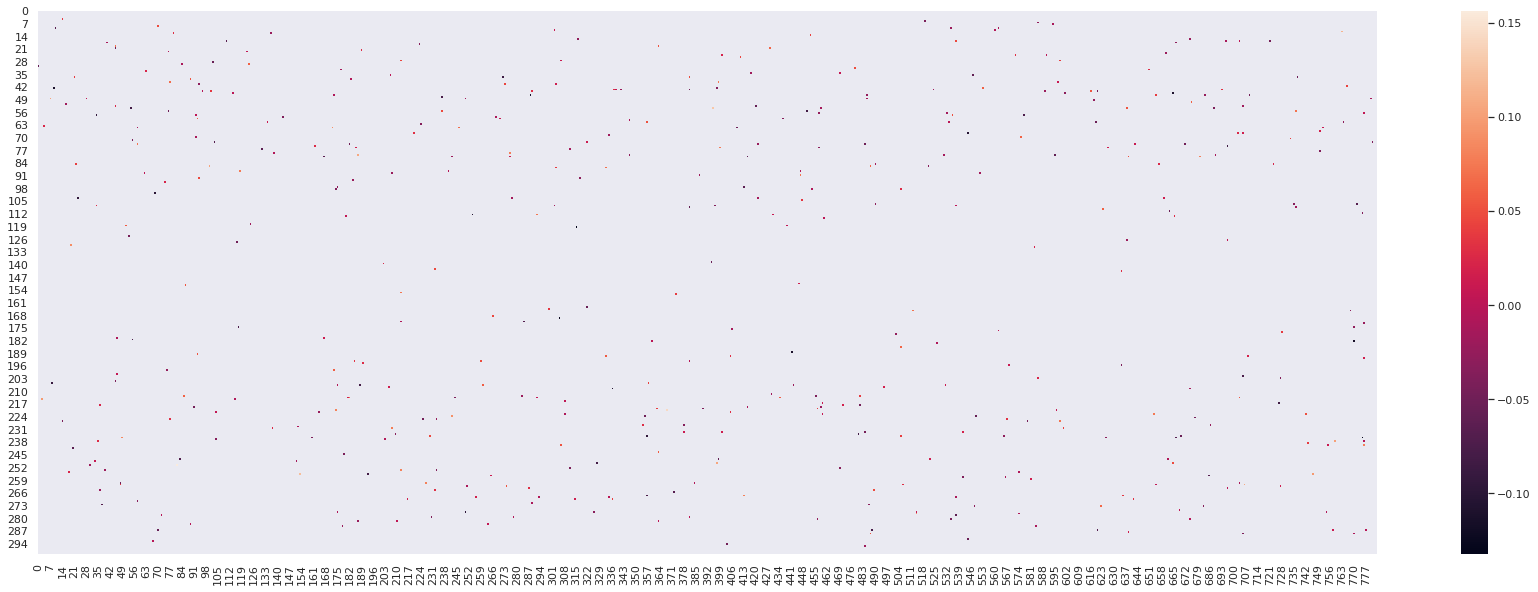

In [170]:
sns.set(rc={'figure.figsize':(30, 10)})
sns.heatmap(t.cpu().numpy(), mask=~mask.cpu().numpy())

<AxesSubplot:>

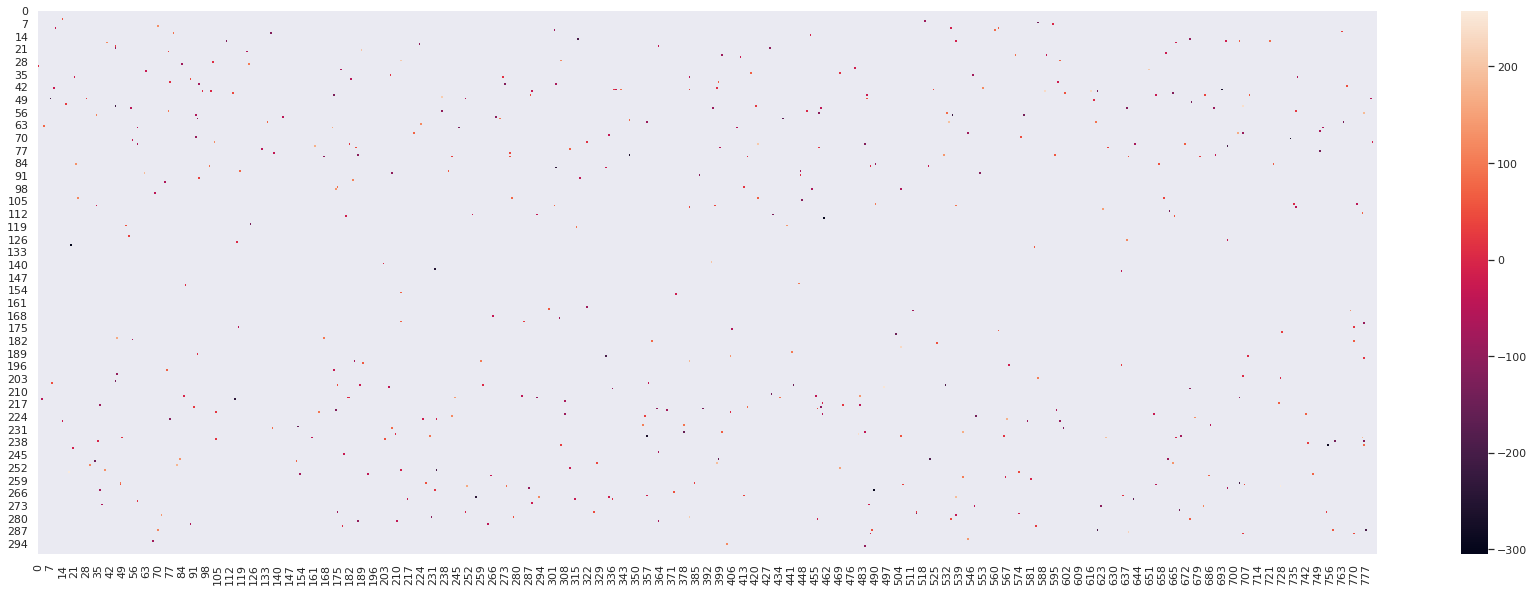

In [175]:
# modified_t = torch.where(mask, 0., t.double())
sns.set(rc={'figure.figsize':(30, 10)})
sns.heatmap(modified_t.cpu().numpy(), mask=~mask.cpu().numpy())

In [12]:
from src.phase_actions import one_shot_pruning

one_shot_pruning(s, expr.pruning_phases[0])

one-shot pruning with uprune until 0.2 sparsity


100%|██████████| 1/1 [00:00<00:00, 24.66it/s]


Exception: ERROR: 52794.0 prunable parameters remaining, expected 53240.0

In [6]:
remaining, total = s.pruner.stats()
remaining/total

0.19832456799398948

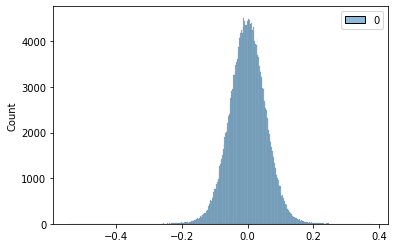

In [4]:
plot_model_weights(s)